In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from utils_unet import * 
from utils_models import * 
from utils_data import *
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
from matplotlib.pyplot import figure
from sklearn.metrics import r2_score, mean_squared_error

from tqdm import tqdm
import pickle

from sklearn.metrics import r2_score, mean_squared_error, f1_score,confusion_matrix

In [5]:
plt.rcParams.update({'font.size': 17})

### Getting data

Here we get data 1985-2011 for train and validation. Train set has 249 time steps.

In [6]:
# define target to be from 'precip_ncep' 'tmp_ncep' 'precip_nasa' 'tmp_nasa'
TARGET = 'precip_ncep'

PATH = '/share/data/willett-group/climate/'

In [7]:
ens_forecasts_all, target_rect, target_for_lags = get_train_val_ens_target(TARGET, PATH)

tmp_precip, rhum, ght, pressure, sst_train, sst_val = get_train_val_obs_data(TARGET, PATH)

mask_US = np.load('train_val/mask_US.npy') 

In [29]:
print(ens_forecasts_all.shape, target_rect.shape, mask_US.shape)
print(tmp_precip.shape, ght.shape, pressure.shape)
print(sst_train.shape, sst_val.shape)

((324, 64, 128), (324, 64, 128), (324, 64, 128))

In [90]:
# let's define positional encoding

grid_lat, grid_lon = np.mgrid[52.75:21.25:64j, 233.25:296.75:128j]

coordinates = np.zeros((2, grid_lat.shape[0], grid_lat.shape[1]))
coordinates[0] = grid_lat
coordinates[1] = grid_lon

PE_dim = 12
pe0 = sinusoid_positional_encoding_ref(64*128, PE_dim, coordinates[0].reshape(64*128))
pe1 = sinusoid_positional_encoding_ref(64*128, PE_dim, coordinates[1].reshape(64*128))

pe_channels = np.zeros((PE_dim*2, 64, 128))
pe_channels[:PE_dim, :, :] = pe0.T.reshape(PE_dim, 64, 128)
pe_channels[-PE_dim:, :, :] = pe1.T.reshape(PE_dim, 64, 128)

In [91]:
train_val_size = 312

In [92]:
sst_ftr = np.concatenate((sst_train[:, :8], sst_val[:, :8]), axis=0)
sst_img = np.zeros((train_val_size, 8, 64, 128))

for i in range(train_val_size):
    for j in range(8): # number of components
        sst_img[i, j, :, :] = np.full((64, 128), sst_ftr[i, j])

In [93]:
# create features 
# it's easy to vary what features to include
if TARGET == 'tmp_ncep' or TARGET == 'precip_ncep':
    dim_shape = 24 + 24 + 5 + 4 + 8
    X_ftrs_hind = np.zeros((312, dim_shape, ens_forecasts_all.shape[2], ens_forecasts_all.shape[3]))
    X_ftrs_hind[:, :24, :, :] = ens_forecasts_all

    for i in range(len(X_ftrs_hind)):
        X_ftrs_hind[i, 24, :, :] = target_for_lags[i+24-2, :, :]
        X_ftrs_hind[i, 25, :, :] = target_for_lags[i+24-3, :, :]
        X_ftrs_hind[i, 26, :, :] = target_for_lags[i+24-4, :, :]
        X_ftrs_hind[i, 27, :, :] = target_for_lags[i+24-12, :, :]
        X_ftrs_hind[i, 28, :, :] = target_for_lags[i+24-24, :, :]

        X_ftrs_hind[i, 29, :, :] = tmp_precip[i+12-2, :, :]
        X_ftrs_hind[i, 30, :, :] = ght[i+12-2, :, :]
        X_ftrs_hind[i, 31, :, :] = pressure[i+12-2, :, :]
        X_ftrs_hind[i, 32, :, :] = rhum[i+12-2, :, :]

    X_ftrs_hind[:, 33:33+2*PE_dim, :, :] = pe_channels
    X_ftrs_hind[:, -8:, :, :] = sst_img
    
elif TARGET == 'tmp_nasa' or TARGET == 'precip_nasa':
    print(TARGET)
    dim_shape = 11 + 4 + 24 + 5 + 8
    X_ftrs_hind = np.zeros((312, dim_shape, ens_forecasts_all.shape[2], ens_forecasts_all.shape[3]))
    X_ftrs_hind[:, :11, :, :] = ens_forecasts_all

    for i in range(len(X_ftrs_hind)):
        X_ftrs_hind[i, 11, :, :] = target_for_lags[i+24-2, :, :]
        X_ftrs_hind[i, 12, :, :] = target_for_lags[i+24-3, :, :]
        X_ftrs_hind[i, 13, :, :] = target_for_lags[i+24-4, :, :]
        X_ftrs_hind[i, 14, :, :] = target_for_lags[i+24-12, :, :]
        X_ftrs_hind[i, 15, :, :] = target_for_lags[i+24-24, :, :]

        X_ftrs_hind[i, 16, :, :] = tmp_precip[i+12-2, :, :]
        X_ftrs_hind[i, 17, :, :] = ght[i+12-2, :, :]
        X_ftrs_hind[i, 18, :, :] = pressure[i+12-2, :, :]
        X_ftrs_hind[i, 19, :, :] = rhum[i+12-2, :, :]

    X_ftrs_hind[:, 20:20+2*PE_dim, :, :] = pe_channels
    X_ftrs_hind[:, -8:, :, :] = sst_img

precip_nasa


In [94]:
print(X_ftrs_hind.shape)

(312, 52, 64, 128)


Let's download our observational climatology: it has shape of our train and validation data. There are 312 steps starting from January.

In [95]:
trend = get_obs_trend(TARGET, PATH)
trend[:, mask_US == 0] = 0

precip


In [31]:
trend_cropped_US = np.zeros((trend.shape[0], 48, 115))

for i in range(trend.shape[0]):
    trend_cropped_US[i] = crop_to_US_land(trend[i])

### Get test data 2011-2020 (2018)

In [32]:
ens_forecasts_all_test, target_test, precip_US_rect_old = get_test_ens_target(TARGET, PATH)
tmp_ssts_test, rhum_test, ght_test, pressure_test = get_test_obs_data(TARGET, PATH)

In [34]:
print(ens_forecasts_all_test.shape, target_test.shape, precip_US_rect_old.shape)    
print(tmp_ssts_test.shape, ght_test.shape, pressure_test.shape)

(85, 11, 64, 128) (96, 64, 128) (312, 64, 128)
(96, 64, 128) (120, 64, 128) (120, 64, 128)


In [36]:
if TARGET == 'precip_nasa' or TARGET == 'tmp_nasa':
    rhum = np.concatenate((rhum[-12:], rhum_test[:-11-24]), axis=0)
    ght = np.concatenate((ght[-12:], ght_test[:-11-24]), axis=0)
    pressure = np.concatenate((pressure[-12:], pressure_test[:-11-24]), axis=0)
    tmp_ssts = np.concatenate((tmp_precip[-12:], tmp_ssts_test[:-11]), axis=0)
elif TARGET == 'precip_ncep':
    print('working with NCEP')
else:
    print('NO DATA')

In [38]:
if 'ncep' in TARGET:
    target_rectarget_for_lags_test = np.concatenate((precip_US_rect_old[-24:], target_test), axis=0)
else:
     target_rectarget_for_lags_test = np.concatenate((precip_US_rect_old[-24:], target_test[:-11]), axis=0)

In [39]:
if 'ncep' in TARGET:
    target_truth_test = target_test[3:] * mask_US
else:
    target_truth_test = target_test[:85] * mask_US

In [41]:
if 'nasa' in TARGET:
    sst_test = np.array(pd.read_pickle(PATH + 'test/sst_monthly_test_100PCs_2mo_offset.pkl'))
    sst_test = sst_test[:, :8]
    sst_ftr = sst_test.copy()
    sst_img_test = np.zeros((96, 8, 64, 128))
    for i in range(96):
        for j in range(8):
            sst_img_test[i, j, :, :] = np.full((64, 128), sst_ftr[i, j])
    sst_img_test = sst_img_test[:-11]
        
elif 'ncep' in TARGET:
    sst_test = np.array(pd.read_pickle(PATH + 'test/sst_monthly_test_100PCs_2mo_offset.pkl'))
    sst_test = sst_test[:, :8]
    sst_ftr = sst_test.copy()
    sst_img_test = np.zeros((120, 8, 64, 128))
    for i in range(120):
        for j in range(8):
            sst_img_test[i, j, :, :] = np.full((64, 128), sst_ftr[i, j])
    sst_img_test = sst_img_test[3:]
else:
    print('NO DATA')


In [43]:
if TARGET == 'tmp_ncep' :
    NUM_STEPS = 93 + 24
    print(TARGET)
    dim_shape = 24 + 5 + 24 + 4 #+ 8
    X_ftrs_test = np.zeros((NUM_STEPS, dim_shape, ens_forecasts_all.shape[2], ens_forecasts_all.shape[3]))
    X_ftrs_test[:, :24, :, :] = ens_forecasts_all_test  

    for i in range(len(X_ftrs_test)):
        X_ftrs_test[i, 24, :, :] = target_rectarget_for_lags_test[i+24+3-2, :, :]
        X_ftrs_test[i, 25, :, :] = target_rectarget_for_lags_test[i+24+3-3, :, :]
        X_ftrs_test[i, 26, :, :] = target_rectarget_for_lags_test[i+24+3-4, :, :]
        X_ftrs_test[i, 27, :, :] = target_rectarget_for_lags_test[i+24+3-12, :, :]
        X_ftrs_test[i, 28, :, :] = target_rectarget_for_lags_test[i+24+3-24, :, :]

        X_ftrs_test[i, 29, :, :] = tmp_ssts_test[i +3  -2, :, :]
        X_ftrs_test[i, 30, :, :] = ght_test[i+3-2, :, :]
        X_ftrs_test[i, 31, :, :] = pressure_test[i+3-2, :, :]
        X_ftrs_test[i, 32, :, :] = rhum_test[i+3-2, :, :]

    X_ftrs_test[:, 33:33+2*PE_dim, :, :] = pe_channels
#     X_ftrs_test[:, -8:, :, :] = sst_img_test
elif TARGET == 'precip_ncep':
    NUM_STEPS = 93 + 24
    print(TARGET)
    dim_shape = 24 + 5 + 24 + 4 + 8
    X_ftrs_test = np.zeros((NUM_STEPS, dim_shape, ens_forecasts_all.shape[2], ens_forecasts_all.shape[3]))
    X_ftrs_test[:, :24, :, :] = ens_forecasts_all_test  

    for i in range(len(X_ftrs_test)):
        X_ftrs_test[i, 24, :, :] = target_rectarget_for_lags_test[i+24+3-2, :, :]
        X_ftrs_test[i, 25, :, :] = target_rectarget_for_lags_test[i+24+3-3, :, :]
        X_ftrs_test[i, 26, :, :] = target_rectarget_for_lags_test[i+24+3-4, :, :]
        X_ftrs_test[i, 27, :, :] = target_rectarget_for_lags_test[i+24+3-12, :, :]
        X_ftrs_test[i, 28, :, :] = target_rectarget_for_lags_test[i+24+3-24, :, :]

        X_ftrs_test[i, 29, :, :] = tmp_ssts_test[i +3  -2, :, :]
        X_ftrs_test[i, 30, :, :] = ght_test[i+3-2, :, :]
        X_ftrs_test[i, 31, :, :] = pressure_test[i+3-2, :, :]
        X_ftrs_test[i, 32, :, :] = rhum_test[i+3-2, :, :]

    X_ftrs_test[:, 33:33+2*PE_dim, :, :] = pe_channels
    X_ftrs_test[:, -8:, :, :] = sst_img_test
          
elif TARGET == 'precip_nasa':
    NUM_STEPS = 85
    print(TARGET)
    dim_shape = 11 + 5 + 24 + 4 + 8
    X_ftrs_test = np.zeros((NUM_STEPS, dim_shape, ens_forecasts_all.shape[2], ens_forecasts_all.shape[3]))
    X_ftrs_test[:, :11, :, :] = ens_forecasts_all_test  #ens_forecasts_numpy_ordered_test

    for i in range(len(X_ftrs_test)):
        X_ftrs_test[i, 11, :, :] = target_rectarget_for_lags_test[i+24-2, :, :]
        X_ftrs_test[i, 12, :, :] = target_rectarget_for_lags_test[i+24-3, :, :]
        X_ftrs_test[i, 13, :, :] = target_rectarget_for_lags_test[i+24-4, :, :]
        X_ftrs_test[i, 14, :, :] = target_rectarget_for_lags_test[i+24-12, :, :]
        X_ftrs_test[i, 15, :, :] = target_rectarget_for_lags_test[i+24-24, :, :]

        X_ftrs_test[i, 16, :, :] = tmp_ssts[i  +12 -2, :, :]
        X_ftrs_test[i, 17, :, :] = ght[i+12-2, :, :]
        X_ftrs_test[i, 18, :, :] = pressure[i+12-2, :, :]
        X_ftrs_test[i, 19, :, :] = rhum[i+12-2, :, :]

    X_ftrs_test[:, 20:20+2*PE_dim, :, :] = pe_channels
    X_ftrs_test[:, -8:, :, :] = sst_img_test
          
elif TARGET == 'tmp_nasa':
    NUM_STEPS = 85
    print(TARGET)
    dim_shape = 11 + 5 + 24 + 4 #+ 8
    X_ftrs_test = np.zeros((NUM_STEPS, dim_shape, ens_forecasts_all.shape[2], ens_forecasts_all.shape[3]))
    X_ftrs_test[:, :11, :, :] = ens_forecasts_all_test  #ens_forecasts_numpy_ordered_test

    for i in range(len(X_ftrs_test)):
        X_ftrs_test[i, 11, :, :] = target_rectarget_for_lags_test[i+24-2, :, :]
        X_ftrs_test[i, 12, :, :] = target_rectarget_for_lags_test[i+24-3, :, :]
        X_ftrs_test[i, 13, :, :] = target_rectarget_for_lags_test[i+24-4, :, :]
        X_ftrs_test[i, 14, :, :] = target_rectarget_for_lags_test[i+24-12, :, :]
        X_ftrs_test[i, 15, :, :] = target_rectarget_for_lags_test[i+24-24, :, :]

        X_ftrs_test[i, 16, :, :] = tmp_ssts[i +12  -2, :, :]
        X_ftrs_test[i, 17, :, :] = ght[i+12-2, :, :]
        X_ftrs_test[i, 18, :, :] = pressure[i+12-2, :, :]
        X_ftrs_test[i, 19, :, :] = rhum[i+12-2, :, :]

    X_ftrs_test[:, 20:20+2*PE_dim, :, :] = pe_channels
#     X_ftrs_test[:, -8:, :, :] = sst_img_test

precip_nasa


In [44]:
print(X_ftrs_test.shape)

(85, 52, 64, 128)


Here we create a new variable with features from train and test, the same for true response.

In [45]:
X_ftrs_hind.shape, X_ftrs_test.shape

((312, 52, 64, 128), (85, 52, 64, 128))

In [46]:
# train + test data
X_ftrs_train_test = np.concatenate((X_ftrs_hind[:249], X_ftrs_test), axis=0)
target_train_test = np.concatenate((target_rect[:249], target_truth_test))

In [47]:
# train + val + test data
X_ftrs_train_val_test = np.concatenate((X_ftrs_hind, X_ftrs_test), axis=0)
target_train_val_test = np.concatenate((target_rect, target_truth_test))
print(X_ftrs_train_val_test.shape, target_train_val_test.shape)

(397, 52, 64, 128) (397, 64, 128)


In [48]:
X_ftrs = X_ftrs_train_val_test.copy() # X_ftrs_train_test.copy()
target_var = target_train_val_test.copy() # target_train_test.copy()

In [49]:
mask_US_cropped = crop_to_US_land(mask_US)

If you'd like to use validation data uncomment:

In [83]:
# X_ftrs = X_ftrs_hind.copy()
# target_var = target_rect.copy()

#### Part for tercile classification

Note that for temperature, we run tercile classification based on regression predictions. Let's define what we'll need for it here:

In [50]:
long_term_pctl_33, long_term_pctl_66 = get_quantiles_33_66(TARGET, PATH)    
print(long_term_pctl_33.shape, long_term_pctl_66.shape)  

geting precip prctl
(312, 64, 128) (312, 64, 128)


In [51]:
long_term_pctl_33[np.isnan(long_term_pctl_33)] = 0
long_term_pctl_66[np.isnan(long_term_pctl_66)] = 0
    
long_term_pctl_33_cropped = np.zeros((312, 48, 115))
for i in range(long_term_pctl_33.shape[0]):
    long_term_pctl_33_cropped[i] = crop_to_US_land(long_term_pctl_33[i])
    
long_term_pctl_66_cropped = np.zeros((312, 48, 115))
for i in range(long_term_pctl_33.shape[0]):
    long_term_pctl_66_cropped[i] = crop_to_US_land(long_term_pctl_66[i])

In [52]:
# here, we create labels for test data
if 'ncep' in TARGET:
    long_term_pctl_33_shift = long_term_pctl_33_cropped[3:3+93+24]
    long_term_pctl_66_shift = long_term_pctl_66_cropped[3:3+93+24]
else:
    long_term_pctl_33_shift = long_term_pctl_33_cropped[:85]
    long_term_pctl_66_shift = long_term_pctl_66_cropped[:85]

In [53]:
train_size = 249

In [54]:
val_cropped_US_test = np.zeros((NUM_STEPS, 48, 115))
for i in range(NUM_STEPS):
    val_cropped_US_test[i] = crop_to_US_land(target_var[train_size:][i])

In [55]:
labels_tercile_test = create_classif_labels_tercile(val_cropped_US_test, long_term_pctl_33_shift, 
                                               long_term_pctl_66_shift, mask_US_cropped)

## Random forest

In [56]:
if TARGET == 'tmp_ncep' or TARGET == 'precip_ncep':
    print('ncep')
    rf_object = generate_RF_predictions(X_ftrs, target_var, mask_US,
                                        drop_positional_encodings=False,
                                        train_size=249, 
                                        positional_encoding_channels=range(33, 33+2*PE_dim))
else:
    print('nasa')
    rf_object = generate_RF_predictions(X_ftrs, target_var, mask_US,
                                        drop_positional_encodings=False, 
                                        train_size=249, 
                                    positional_encoding_channels=range(20, 20+2*PE_dim))

nasa


In [57]:
rf_object.train_model()
rf_preds = rf_object.return_predictions(include='all', output_format='grid', 
                                         output_original_grid=False)

In [58]:
target_var_cropped_US = np.zeros((target_var.shape[0], 48, 115))

for i in range(target_var.shape[0]):
    target_var_cropped_US[i] = crop_to_US_land(target_var[i])

In [59]:
test_size = 312

In [78]:
rf_preds[:, mask_US_cropped == 0] = 0

print(TARGET, 'RF test: mean, std, SE, percentile:', 
      model_performance(rf_preds[test_size:, mask_US_cropped==1], 
                        target_var_cropped_US[test_size:, mask_US_cropped==1]))

precip_ncep RF test: mean, std, SE, percentile: [2.17 2.02 0.04 1.48 3.03 4.45]


In [80]:
rf_preds[:, mask_US_cropped == 0] = 0

print(TARGET, 'RF validation: mean, std, SE, percentile:', 
      model_performance(rf_preds[train_size:test_size, mask_US_cropped==1], 
                        target_var_cropped_US[train_size:test_size, mask_US_cropped==1]))

precip_ncep RF validation: mean, std, SE, percentile: [1.89 1.71 0.03 1.36 2.68 4.08]


In [192]:
rf_preds[:, mask_US_cropped == 0] = 0

print(TARGET, 'RF test: mean, std, SE, percentile:', 
      model_performance(rf_preds[test_size:, mask_US_cropped==1], 
                        target_var_cropped_US[test_size:, mask_US_cropped==1]))

tmp_nasa RF test: mean, std, SE, percentile: [3.03 1.12 0.02 2.94 3.69 4.25]


In [60]:
rf_preds[:, mask_US_cropped == 0] = 0

print(TARGET, 'RF test: mean, std, SE, percentile:', 
      model_performance(rf_preds[test_size:, mask_US_cropped==1], 
                        target_var_cropped_US[test_size:, mask_US_cropped==1]))

precip_nasa RF test: mean, std, SE, percentile: [2.17 2.14 0.04 1.55 2.86 4.44]


In [42]:
rf_preds[:, mask_US_cropped == 0] = 0

print(TARGET, 'RF test: mean, std, SE, percentile:', 
      model_performance(rf_preds[test_size:, mask_US_cropped==1], 
                        target_var_cropped_US[test_size:, mask_US_cropped==1]))

tmp_ncep RF test: mean, std, SE, percentile: [3.17 1.15 0.02 2.99 3.76 4.63]


Let's check tercile classification performance:

In [52]:
print('RF tercile', TARGET)
preds_terc = create_classif_labels_tercile(rf_preds[test_size:], long_term_pctl_33_shift, 
                                               long_term_pctl_66_shift, mask_US_cropped)

heatmap_terc = report_terc_scores(labels_tercile[:, mask_US_cropped==1], preds_terc[:, mask_US_cropped==1])

RF tercile tmp_ncep
Mean acc, median acc, SE: 58.07 54.70 0.27


In [46]:
print('RF tercile', TARGET)
preds_terc = create_classif_labels_tercile(rf_preds[test_size:], long_term_pctl_33_shift, 
                                               long_term_pctl_66_shift, mask_US_cropped)

heatmap_terc = report_terc_scores(labels_tercile[:, mask_US_cropped==1], preds_terc[:, mask_US_cropped==1])

RF tercile tmp_nasa
Mean acc, median acc, SE: 58.78 55.29 0.26


In [105]:
rf_preds[:, mask_US_cropped == 0] = 0

print(TARGET, 'RF test: mean, std, SE, percentile:', 
      model_performance(rf_preds[test_size:, mask_US_cropped==1], 
                        target_var_cropped_US[test_size:, mask_US_cropped==1]))

tmp_nasa RF test: mean, std, SE, percentile: [3.03 1.12 0.02 2.94 3.69]


In [77]:
train_size = 249
rf_preds[:, mask_US_cropped == 0] = 0

print(TARGET, 'RF test: mean, std, SE, percentile:', 
      model_performance(rf_preds[test_size:, mask_US_cropped==1], 
                        target_var_cropped_US[test_size:, mask_US_cropped==1]))

precip_ncep RF test: mean, std, SE, percentile: [2.17 2.02 0.04 1.48 3.03 4.45]


For $R^2$ score we should detrend our data. Here we work with test data

In [68]:
if 'ncep' in TARGET:
    # shift trend for NCEP data
    rf_preds_test_detrended = rf_preds[test_size:] - trend_cropped_US[3:3+93+24]
else: 
    rf_preds_test_detrended = rf_preds[test_size:] - trend_cropped_US[:85]

In [69]:
if 'ncep' in TARGET:
    # shift trend for NCEP data
    target_test_detrended = target_var_cropped_US[test_size:] - trend_cropped_US[3:3+93+24]
else:
    target_test_detrended = target_var_cropped_US[test_size:] - trend_cropped_US[:85]

In [83]:
print(TARGET, 'test scores of RF')
r2_test_rf = avg_r2(target_test_detrended, rf_preds_test_detrended,  
                    mask_US_cropped)

precip_ncep test scores of RF
Avg r2 : -0.11 
Median r2: -0.01  


In [70]:
print(TARGET, 'scores of RF')
r2_test_rf = avg_r2(target_test_detrended, rf_preds_test_detrended,  
                    mask_US_cropped)

precip_nasa scores of RF
Avg r2 : -0.18 
Median r2: -0.11  


In [108]:
print(TARGET, 'scores of RF')
r2_test_rf = avg_r2(target_test_detrended, rf_preds_test_detrended,  
                    mask_US_cropped)

tmp_nasa scores of RF
Avg r2 : 0.20 
Median r2: 0.22  


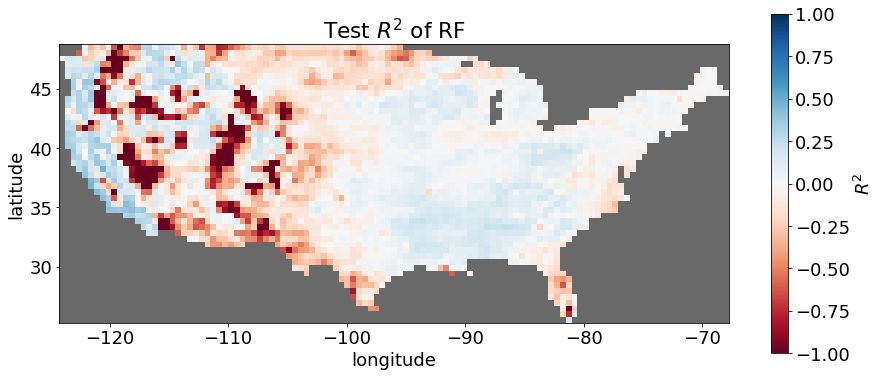

In [128]:
r2_test_rf[mask_US_cropped == 0] = np.float('NaN')
cmap = plt.cm.RdBu
cmap.set_bad('dimgrey',1.)
plt.imshow(r2_test_rf, extent=(-124.25,-67.75,25.25,48.75), cmap=cmap)
plt.title('Test $R^2$ of RF')
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.clim(-1,1)
cbar = plt.colorbar(shrink=0.5)
plt.gcf().set_size_inches(15,12.5)
cbar.set_label('$R^2$')
# plt.savefig('images/precip/test_stack_ncep_precip.pdf', bbox_inches='tight')

## Linear regression 

In [94]:
preds_lr_all = get_weighted_pred_LR_test(X_ftrs, target_var, mask_US, train_size=249)

In [95]:
preds_lr_all.shape

(429, 64, 128)

In [51]:
train_size = 249

print(TARGET, 'LR test: mean, std, SE, percentile:', 
      model_performance(preds_lr_all[test_size:, mask_US==1], 
                        target_var_cropped_US[test_size:, mask_US_cropped==1]))

tmp_nasa LR test: mean, std, SE, percentile: [3.09 1.06 0.02 3.04 3.72 4.26]


In [195]:
train_size = 249

print(TARGET, 'LR test: mean, std, SE, percentile:', 
      model_performance(preds_lr_all[test_size:, mask_US==1], 
                        target_var_cropped_US[test_size:, mask_US_cropped==1]))

tmp_nasa LR test: mean, std, SE, percentile: [3.09 1.06 0.02 3.04 3.72 4.26]


In [96]:
train_size = 249

print(TARGET, 'LR test: mean, std, SE, percentile:', 
      model_performance(preds_lr_all[test_size:, mask_US==1], 
                        target_var_cropped_US[test_size:, mask_US_cropped==1]))

precip_ncep LR test: mean, std, SE, percentile: [2.71 2.59 0.05 1.91 3.75 5.45]


In [97]:
preds_lr_all_cropped = np.zeros((preds_lr_all.shape[0], 48, 115))

for i in range(preds_lr_all.shape[0]):
    preds_lr_all_cropped[i] = crop_to_US_land(preds_lr_all[i])

In [99]:
if 'ncep' in TARGET:
    # shift trend for NCEP data
    preds_lr_crop_detrended = preds_lr_all_cropped[test_size:] - trend_cropped_US[3:3+93+24]
else: 
    preds_lr_crop_detrended = preds_lr_all_cropped[test_size:] - trend_cropped_US[:85]

In [100]:
print(TARGET, 'scores of LR')
r2_test_lr_all = avg_r2(target_test_detrended, preds_lr_crop_detrended,  
                    mask_US_cropped)

precip_ncep scores of LR
Avg r2 : -0.33 
Median r2: -0.25  


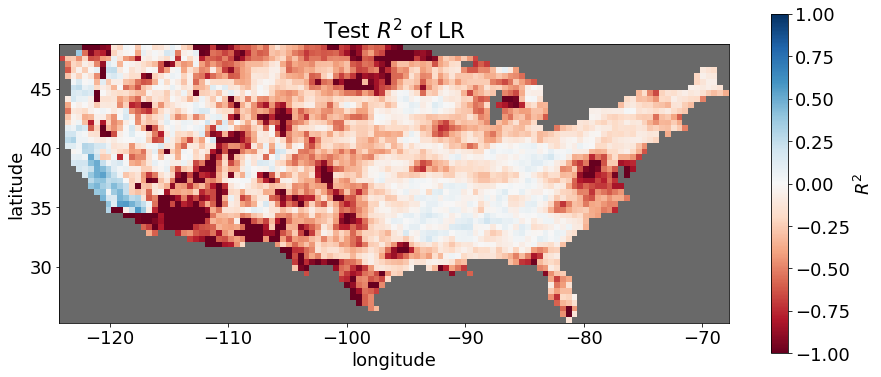

In [157]:
r2_test_rf[mask_US_cropped == 0] = np.float('NaN')
cmap = plt.cm.RdBu
cmap.set_bad('dimgrey',1.)
plt.imshow(r2_test_lr_all, extent=(-124.25,-67.75,25.25,48.75), cmap=cmap)
plt.title('Test $R^2$ of LR')
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.clim(-1,1)
cbar = plt.colorbar(shrink=0.5)
plt.gcf().set_size_inches(15,12.5)
cbar.set_label('$R^2$')

## Ensemble average

For evaluation of the ensemble average, we use its own climatology. 

In [61]:
ens_climatology = get_ens_climatology(TARGET, path='')

if 'ncep' in TARGET:
    ens_avg_shat_repeated = np.zeros((120, 64, 128))
    num_years = 10
    for i in range(num_years):
        ens_avg_shat_repeated[12*i:12*(i+1),:,:] = ens_climatology * mask_US

    ens_avg_shat_repeated = ens_avg_shat_repeated[3:]
else:
    ens_avg_shat_repeated = np.zeros((96, 64, 128))
    for i in range(8):
        ens_avg_shat_repeated[12*i:12*(i+1),:,:] = ens_climatology * mask_US

    ens_avg_shat_repeated = ens_avg_shat_repeated[:-11]

In [62]:
ens_avg_shat_repeated.shape

(85, 64, 128)

In [63]:
ens_climatology_cropped_US = np.zeros((NUM_STEPS, 48, 115))
for i in range(NUM_STEPS):
    ens_climatology_cropped_US[i] = crop_to_US_land(ens_avg_shat_repeated[i])

In [64]:
ens_avg_test = np.mean(ens_forecasts_all_test, axis=1)
ens_avg_test.shape

(85, 64, 128)

In [65]:
ens_avg_test_cropped_US = np.zeros((NUM_STEPS, 48, 115))
for i in range(NUM_STEPS):
    ens_avg_test_cropped_US[i] = crop_to_US_land(ens_avg_test[i] * mask_US)

In [66]:
ens_avg_test_detrended = ens_avg_test_cropped_US - ens_climatology_cropped_US

In [56]:
print(TARGET, 'Ens avg test: mean, std, SE, percentile:', 
      model_performance(ens_avg_test_detrended[:, mask_US_cropped==1], 
                        target_test_detrended[:, mask_US_cropped==1]))

precip_nasa Ens avg test: mean, std, SE, percentile: [2.13 2.17 0.04 1.52 2.85 4.31]


In [71]:
print(TARGET, 'Ens avg test: mean, std, SE, percentile:', 
      model_performance(ens_avg_test_detrended[:, mask_US_cropped==1], 
                        target_test_detrended[:, mask_US_cropped==1]))

precip_nasa Ens avg test: mean, std, SE, percentile: [2.13 2.17 0.04 1.52 2.85 4.31]


In [58]:
print(TARGET, 'Ens avg test: mean, std, SE, percentile:', 
      model_performance(ens_avg_test_detrended[:, mask_US_cropped==1], 
                        target_test_detrended[:, mask_US_cropped==1]))

tmp_nasa Ens avg test: mean, std, SE, percentile: [4.82 5.65 0.1  3.43 4.56 7.82]


In [107]:
print(TARGET, 'Ens avg test: mean, std, SE, percentile:', 
      model_performance(ens_avg_test_detrended[:, mask_US_cropped==1], 
                        target_test_detrended[:, mask_US_cropped==1]))

precip_ncep Ens avg test: mean, std, SE, percentile: [2.19 2.09 0.04 1.55 2.97 4.57]


In [108]:
print(TARGET, 'scores of ens avg')
r2_test_ens = avg_r2(target_test_detrended, ens_avg_test_detrended,  
                    mask_US_cropped)

precip_ncep scores of ens avg
Avg r2 : -0.08 
Median r2: 0.01  


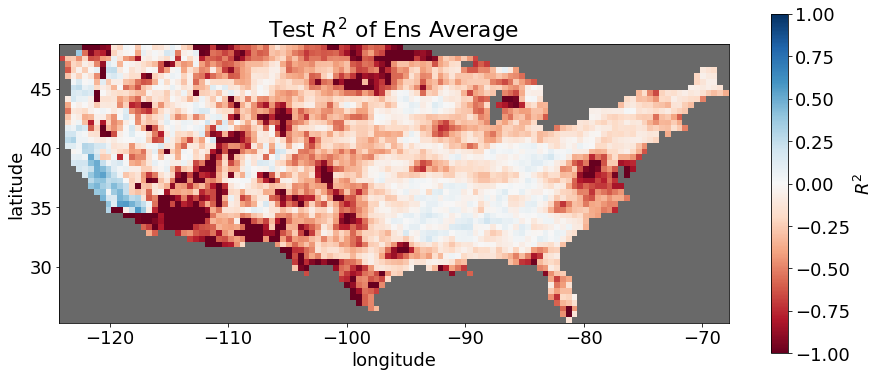

In [183]:
r2_test_rf[mask_US_cropped == 0] = np.float('NaN')
cmap = plt.cm.RdBu
cmap.set_bad('dimgrey',1.)
plt.imshow(r2_test_lr_all, extent=(-124.25,-67.75,25.25,48.75), cmap=cmap)
plt.title('Test $R^2$ of Ens Average')
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.clim(-1,1)
cbar = plt.colorbar(shrink=0.5)
plt.gcf().set_size_inches(15,12.5)
cbar.set_label('$R^2$')

## Historical average

In [88]:
print(TARGET, 'scores of hist avg')
zeros_pred = np.zeros((NUM_STEPS, 48, 115))
ens_r2_all_test_hist = avg_r2(target_test_detrended, zeros_pred, 
                                             mask_US_cropped)

precip_nasa scores of hist avg
Avg r2 : -0.07 
Median r2: -0.02  


In [109]:
print(TARGET, 'scores of hist avg')
zeros_pred = np.zeros((NUM_STEPS, 48, 115))
ens_r2_all_test_hist = avg_r2(target_test_detrended, zeros_pred, 
                                             mask_US_cropped)

precip_ncep scores of hist avg
Avg r2 : -0.06 
Median r2: -0.01  


In [57]:
print(TARGET, 'scores of hist avg')
zeros_pred = np.zeros((NUM_STEPS, 48, 115))
ens_r2_all_test_hist = avg_r2(target_test_detrended, zeros_pred, 
                                             mask_US_cropped)

precip_nasa scores of hist avg
Avg r2 : -0.07 
Median r2: -0.02  


In [59]:
print(TARGET, 'scores of hist avg')
zeros_pred = np.zeros((NUM_STEPS, 48, 115))
ens_r2_all_test_hist = avg_r2(target_test_detrended, zeros_pred, 
                                             mask_US_cropped)

tmp_nasa scores of hist avg
Avg r2 : -0.70 
Median r2: -0.20  


In [110]:
print(TARGET, 'Historical avg test: mean, std, SE, percentile:', 
      model_performance(zeros_pred[:, mask_US_cropped==1], 
                        target_test_detrended[:, mask_US_cropped==1]))

precip_ncep Historical avg test: mean, std, SE, percentile: [2.33 2.35 0.04 1.59 3.2  4.96]


In [60]:
print(TARGET, 'Historical avg test: mean, std, SE, percentile:', 
      model_performance(zeros_pred[:, mask_US_cropped==1], 
                        target_test_detrended[:, mask_US_cropped==1]))

tmp_nasa Historical avg test: mean, std, SE, percentile: [6.49 6.15 0.11 5.06 6.92 9.72]


In [89]:
print(TARGET, 'Historical avg test: mean, std, SE, percentile:', 
      model_performance(zeros_pred[:, mask_US_cropped==1], 
                        target_test_detrended[:, mask_US_cropped==1]))

precip_nasa Historical avg test: mean, std, SE, percentile: [2.14 2.29 0.04 1.51 2.81 4.4 ]


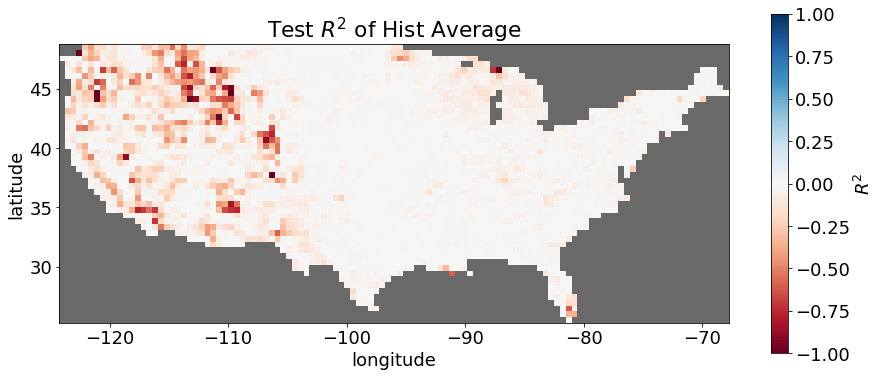

In [189]:
r2_test_rf[mask_US_cropped == 0] = np.float('NaN')
cmap = plt.cm.RdBu
cmap.set_bad('dimgrey',1.)
plt.imshow(ens_r2_all_test_hist, extent=(-124.25,-67.75,25.25,48.75), cmap=cmap)
plt.title('Test $R^2$ of Hist Average')
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.clim(-1,1)
cbar = plt.colorbar(shrink=0.5)
plt.gcf().set_size_inches(15,12.5)
cbar.set_label('$R^2$')